In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas.api.types as ptypes
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.manifold import TSNE
%matplotlib inline

In [9]:
def Normalizedata(data,ids):
    for i in ids:
        x2v = x[i].values.reshape(-1, 1)
        x2v = min_max_scaler.fit_transform(x2v)
        x[i] = x2v
def calculate_mean_window(c,vector):
    if vector.shape[0]%c !=0:
        rem = vector.shape[0]%c
        needed = c-rem
        needed = np.zeros(c-rem)
        vector = np.concatenate([vector,needed])
    vector = np.reshape(vector,(c,-1))
    vector = np.mean(vector,axis=0)
    return vector

def seperate_dataset(data):
    return data[2].mean(),data[8].mean(),data[9].mean(),data[10].mean()


def Process_data(data,window):
    times = int(data.shape[0]/window)
    draw_data = np.zeros((times+1,4))
    for i in range(times+1):
        draw_data[i] = seperate_dataset(data[i*window:(i+1)*window])
    return draw_data

def plotdata(data,window,i=None):
    draw_data1 = Process_data(data[data[5]=='Test'],window)
    
    plt.figure(figsize=(12,6))
    plt.plot(draw_data1[:,0],c='green',label='Average reward')
    plt.plot(draw_data1[:,1],c='red',label='Average eaten food')
    plt.plot(draw_data1[:,2],c='blue',label='Stps Hom N')
    plt.plot(draw_data1[:,3],c='purple',label='Stps Hom M')
    plt.xlabel('Sum of {} episode'.format(window))
    plt.ylabel('Count')
    plt.title('Over Testing Episodes,Model:{}'.format(i))
    plt.legend()
    
    draw_data = Process_data(data[data[5]=='train'],window)
    plt.figure(figsize=(12,6))
    plt.plot(draw_data[:,0],c='green',label='Average reward')
    plt.plot(draw_data[:,1],c='red',label='Average eaten food')
    plt.plot(draw_data[:,2],c='blue',label='Stps Hom N')
    plt.plot(draw_data[:,3],c='purple',label='Stps Hom M')
    plt.xlabel('Sum of {} episode'.format(window))
    plt.ylabel('Count')
    plt.title('Over training Episodes, Model:{}'.format(i))
    plt.legend()
    #draw_data(data[data[5]=='train'],window)
    return draw_data,draw_data1

def rose_plot(model,x,cycles=2,combined=False,length=80):
    print('Model:{}'.format(model))
    XH = (x=='XH').values.sum(axis=0)
    EH = (x=='EH').values.sum(axis=0)
    XF = (x=='XF').values.sum(axis=0)
    EF = (x=='EF').values.sum(axis=0)
    rose_neurons={'Exit Home':XH,'Enter Home':EH,'Exit Food':XF,'Enter Food Area':EF}
    plt.rcParams['figure.figsize'] = (8, 8)

    
    bins = int(length/cycles if combined else length)
    factor = 360/bins
    if combined:
        for j in rose_neurons.keys():
            rose_neurons[j] = rose_neurons[j].reshape((cycles,-1)).sum(axis=0)
    #Array with the angles of bins
    Angels = [i*factor for i in range(bins)]
    RadAngels = np.deg2rad(Angels)
    labels = [str(binn) for binn in range(bins)]
    counter=0

    #Loop over the picked neurons
    for j in rose_neurons.keys():

        #Making the plot polar.
        ax = plt.subplot(2,2,1+counter,projection='polar')
        
        #Draw the rose table using matplotlib
        ax.bar(RadAngels,rose_neurons[j],width=2*np.pi/bins,edgecolor='blue', color='None')
        ax.set_xlabel('Time step')
        if combined:
            tick = length/(cycles*8)
        else:
            tick = length/8
            
            
        ax.set_xticklabels([0,tick,'Morning',tick*3,tick*4,tick*5,'Night',tick*7])
            
        ax.set_title('{}'.format(j),pad=15)
        counter+=1

    plt.tight_layout()
    
def Calculate_TSNE(data,seed=10,n_comp=2,counter=80):
    for j in range(10):
        y = TSNE(n_components=n_comp, perplexity=j*5,random_state=seed).fit_transform(data)

        fig, ax = plt.subplots()
        fig.set_figheight(7)
        fig.set_figwidth(7)
        ax.scatter(x=y[:,0],y=y[:,1])
        for i in range(counter):
            ax.annotate(str(i), (y[i,0], y[i,1]))
        plt.title('perplixty:{}'.format(j*5))
        #plt.ylim(0,1)
        #plt.xlim(-3,-2)
        plt.show()
        
def neuron_activity(data,cycles=2,day_duration=40):
    plt.figure()
    plt.plot(data)
    for i in range(cycles):
        plt.axvspan(i*day_duration+20,i*day_duration+40,color='black',alpha=0.1)
        
###Read hidden states and rose diagram data for a model with for types of input
def Read_Data(model):
    hs={}
    d={}
    hs['00000000'] = np.load('output/{}/lstm_states_00000000.npy'.format(model))
    hs['10000000'] = np.load('output/{}/lstm_states_10000000.npy'.format(model))
    hs['10100000'] = np.load('output/{}/lstm_states_10100000.npy'.format(model))
    hs['11111111'] = np.load('output/{}/lstm_states_11111111.npy'.format(model))
    hs['10101010'] = np.load('output/{}/lstm_states.npy'.format(model))

    d['00000000'] = pd.read_csv('output/{}/states_00000000.csv'.format(model),header=None)
    d['10000000'] = pd.read_csv('output/{}/states_10000000.csv'.format(model),header=None)
    d['10100000'] = pd.read_csv('output/{}/states_10100000.csv'.format(model),header=None)
    d['11111111'] = pd.read_csv('output/{}/states_11111111.csv'.format(model),header=None)
    d['10101010'] = pd.read_csv('output/{}/df.csv'.format(model),header=None)
    return hs,d

def rose_plot_compare(xs={},cycles=2,combined=False,length=80):
    rose_neurons={}
    for i in xs.keys():
        rose_neurons[i]=(xs[i]=='XF').values.sum(axis=0)
    plt.rcParams['figure.figsize'] = (16, 16)

    
    bins = int(length/cycles if combined else length)
    factor = 360/bins
    if combined:
        for j in rose_neurons.keys():
            rose_neurons[j] = rose_neurons[j].reshape((cycles,-1)).sum(axis=0)
    #Array with the angles of bins
    Angels = [i*factor for i in range(bins)]
    RadAngels = np.deg2rad(Angels)
    labels = [str(binn) for binn in range(bins)]
    counter=0
    n_bins = cycles*2
    n_bins = [i*(360/n_bins) for i in range(bins)]
    n_nights = 2 if combined else cycles*2
    
    
    #Loop over the picked neurons
    for j in rose_neurons.keys():

        #Making the plot polar.
        ax = plt.subplot(2,3,1+counter,projection='polar')
        #Draw the rose table using matplotlib
        ax.bar(RadAngels,rose_neurons[j],width=2*np.pi/bins,edgecolor='blue', color='None')
        ax.bar(np.deg2rad(45+45/2),max(rose_neurons[j]),width=np.pi/4,facecolor='black',alpha=0.1)
        ax.set_xlabel('Time step')
        if combined:
            tick = length/(cycles*8)
        else:
            tick = length/8
        ax.set_xticklabels([0,tick,'Morning',tick*3,tick*4,tick*5,'Night',tick*7])
        ax.set_title('{}'.format(j),pad=15)
        counter+=1
    plt.tight_layout()
    return rose_neurons

### adding a clue 22-28

/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


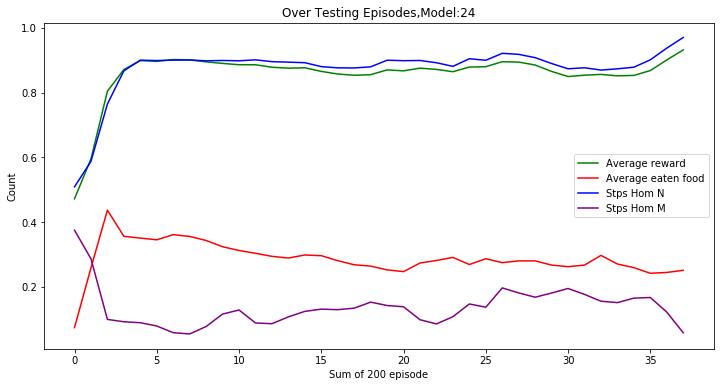

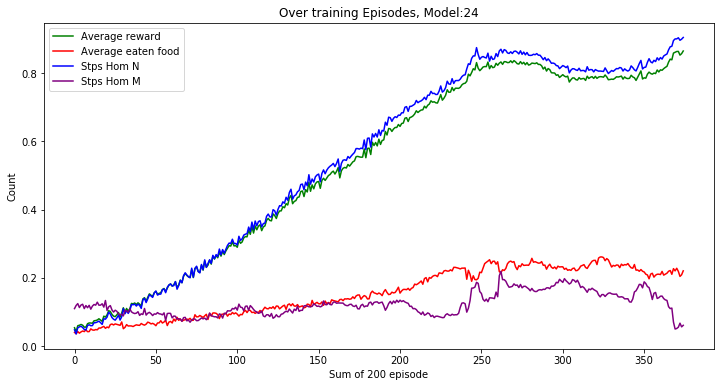

In [24]:
for i in range(24,25):
    x = pd.read_csv('output/{}/exp_details.csv'.format(i),header=None)
    Normalizedata(x,[2,8,9,10])
    plotdata(x,200,i)

Model:24


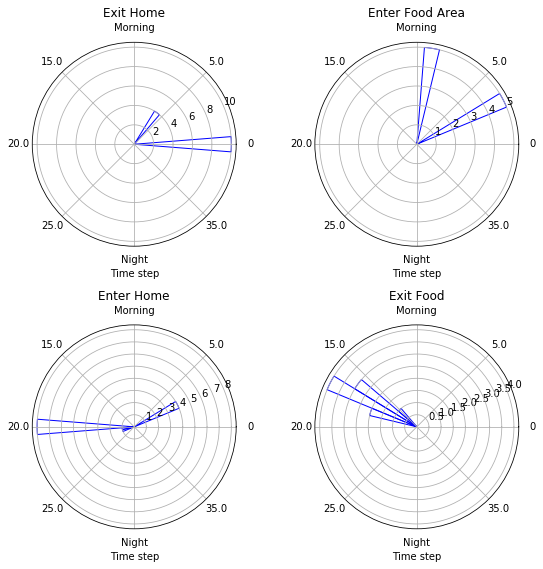

In [9]:
rose_plot_hidden(24,combined=True)

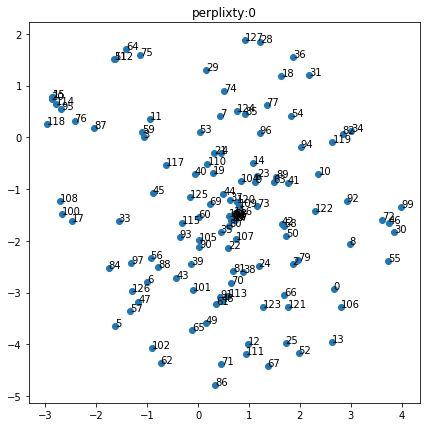

In [31]:
Calculate_TSNE(hidden_states[0,:,:].T,seed=1377)


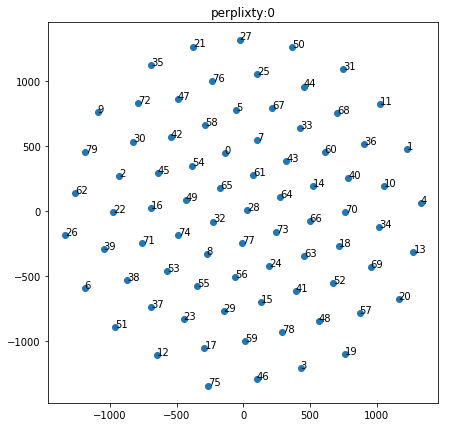

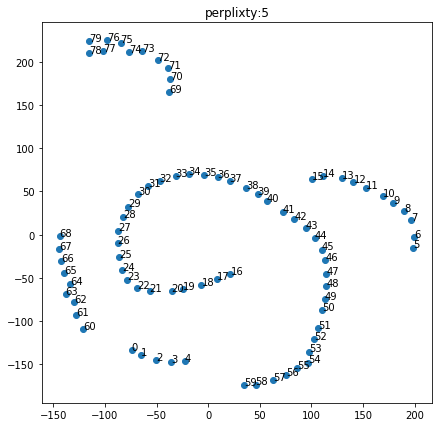

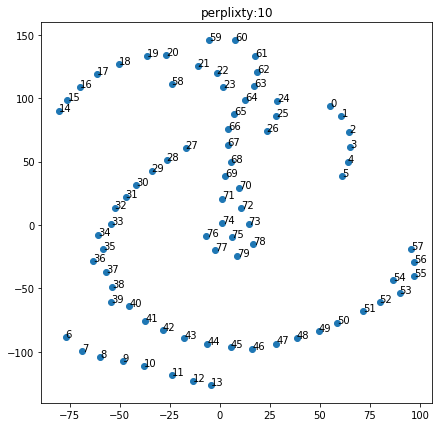

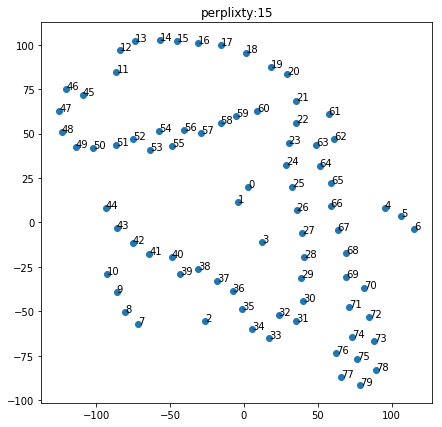

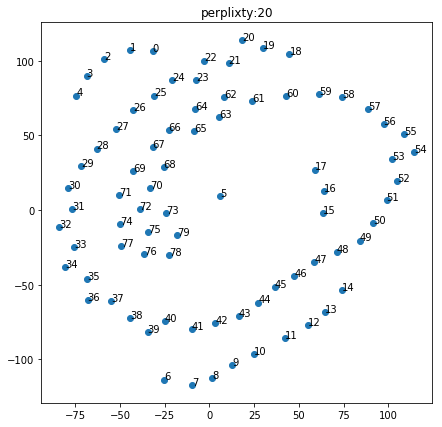

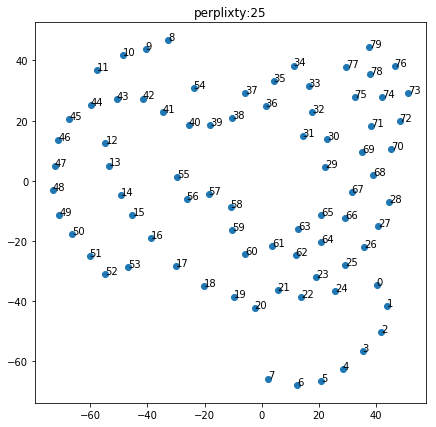

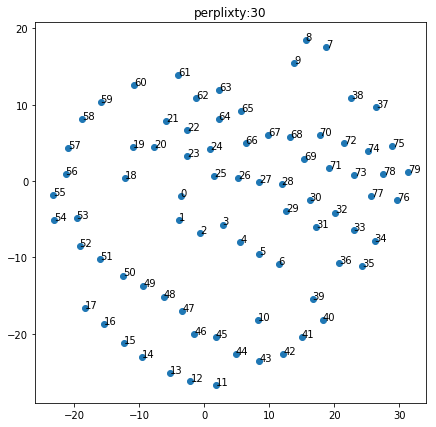

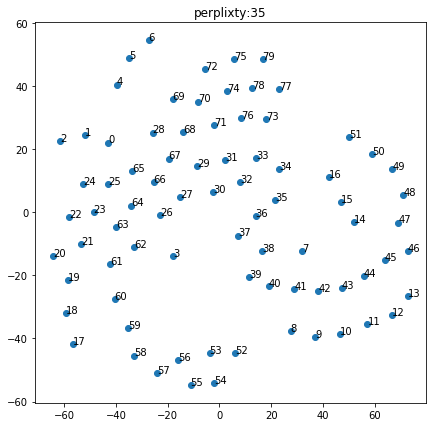

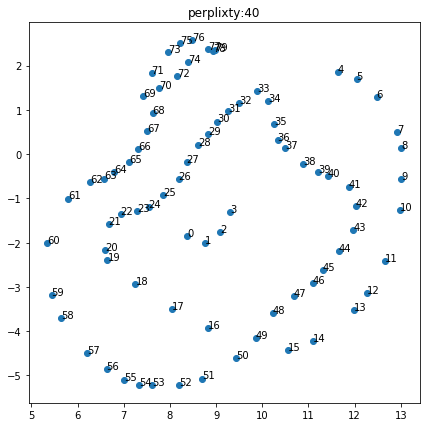

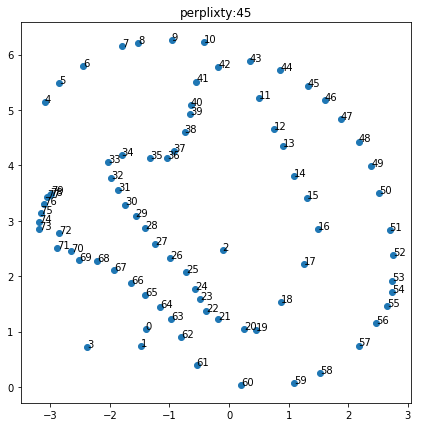

In [45]:
Calculate_TSNE(hidden_states[0,:,:],seed=1377)

In [7]:
y = TSNE(n_components=1, perplexity=25,random_state=1377).fit_transform(hidden_states.mean(axis=0))

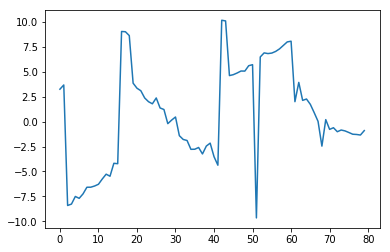

In [8]:
plt.plot(y)

###### for j in range(10):
    y = TSNE(perplexity=j*5).fit_transform(hidden_states[0,:,:])

    fig, ax = plt.subplots()
    ax.scatter(x=y[:,0],y=y[:,1])
    for i in range(80):
        ax.annotate(str(i), (y[i,0], y[i,1]))
    plt.title('perplixty:{}'.format(j*5))
    plt.show()

In [4]:
hidden_states = np.load('output/24/lstm_states.npy')

### The lstm hidden states that show response to time.

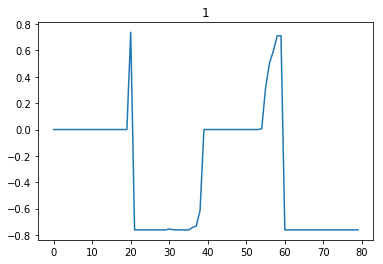

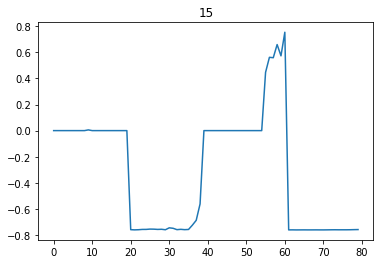

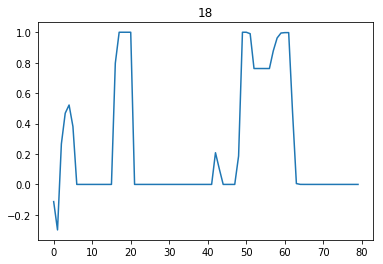

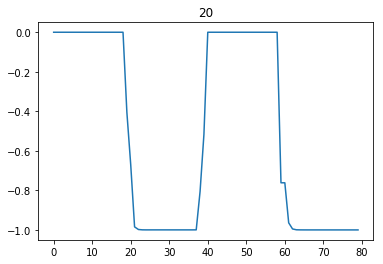

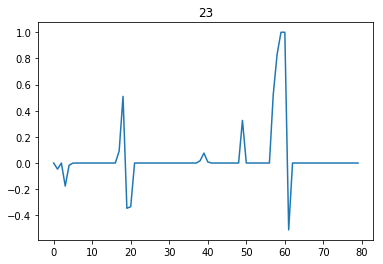

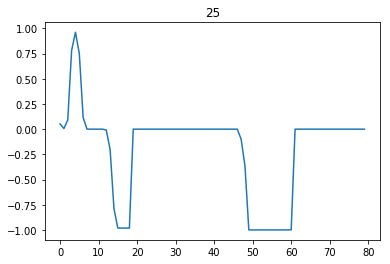

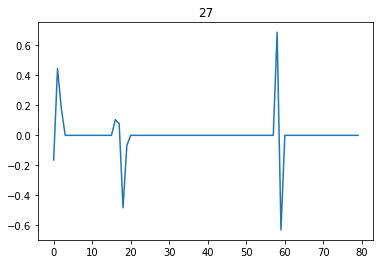

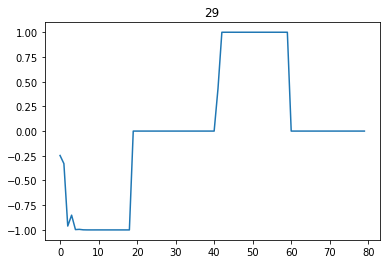

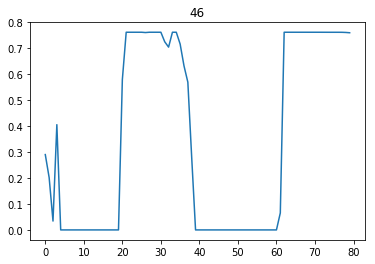

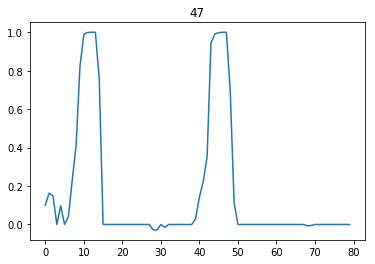

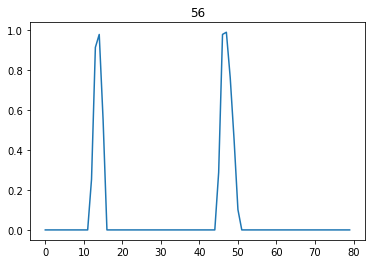

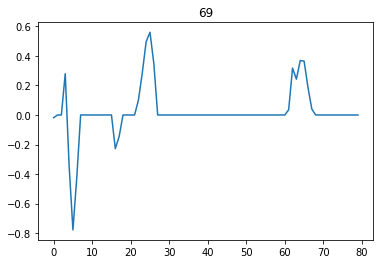

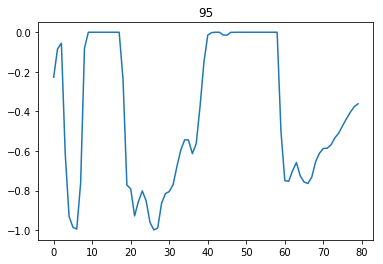

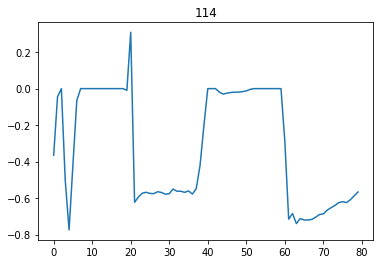

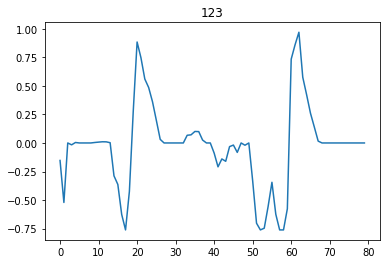

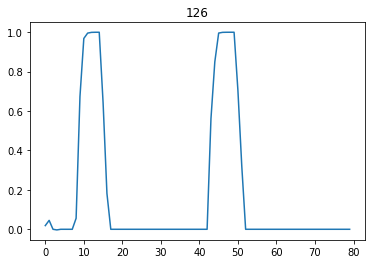

In [32]:
important_lstm_nodes = [1,15,18,20,23,25,27,29,46,47,56,69,95,114,123,126]
for i in important_lstm_nodes:
    plt.figure()
    plt.plot(hidden_states[0,:,i])
    plt.title(i)

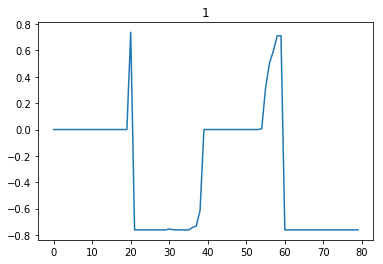

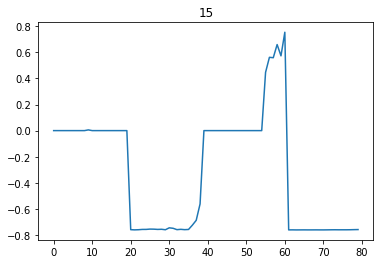

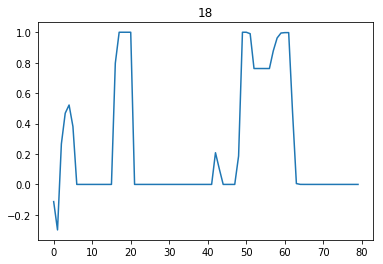

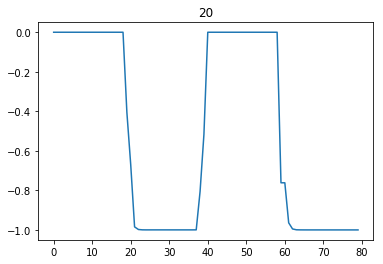

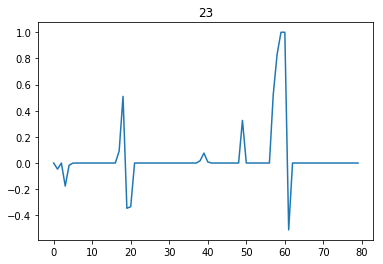

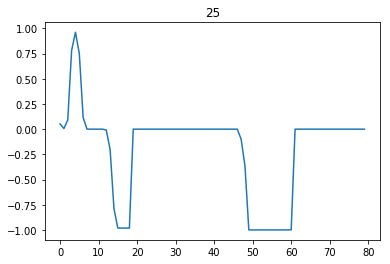

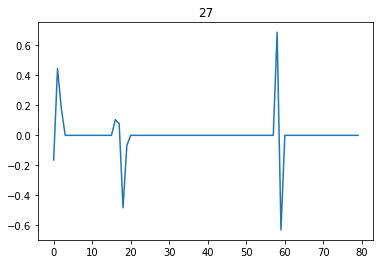

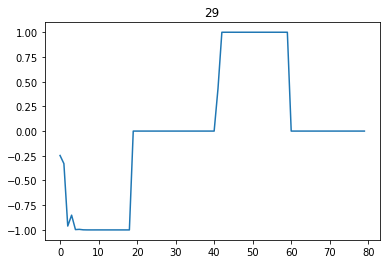

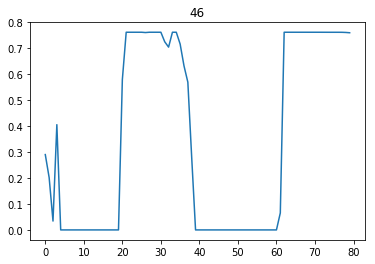

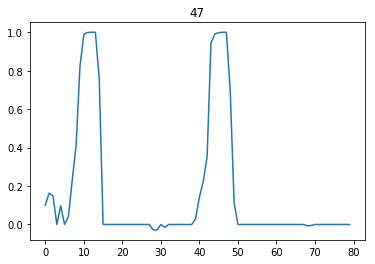

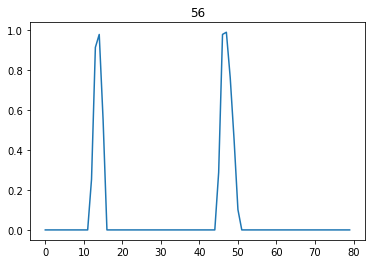

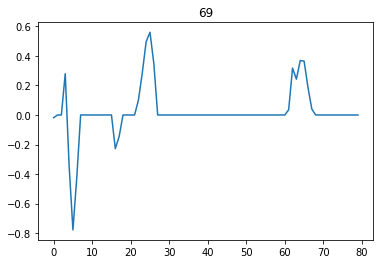

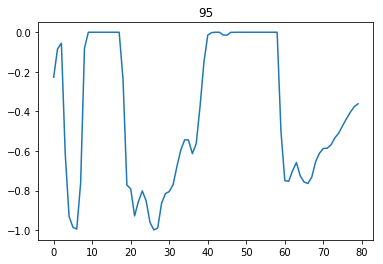

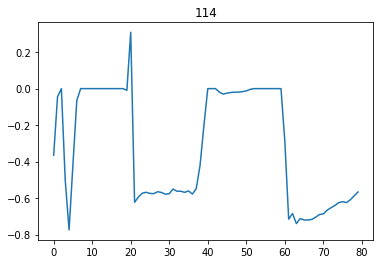

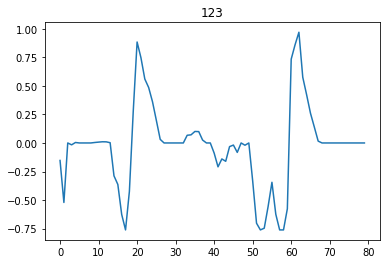

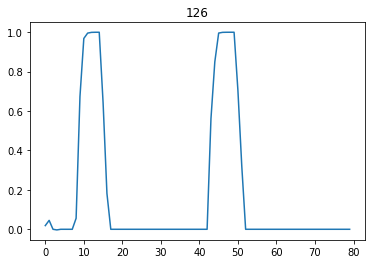

In [5]:
important_lstm_nodes = [1,15,18,20,23,25,27,29,46,47,56,69,95,114,123,126]
for i in important_lstm_nodes:
    plt.figure()
    plt.plot(hidden_states[0,:,i])
    plt.title(i)

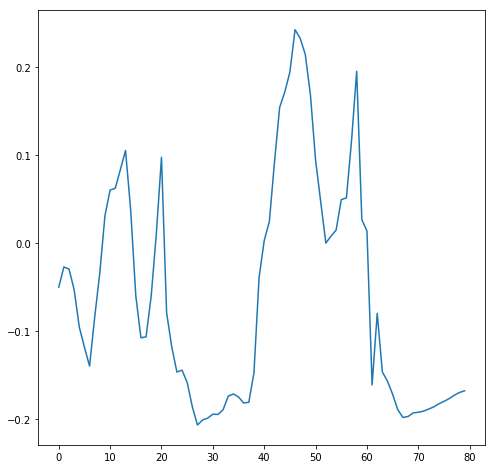

In [28]:
plt.plot(means[:,important_lstm_nodes].mean(axis=1))

### Experiment:64- 4 days

/gpfs/hpchome/labash/miniconda3/envs/PT/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


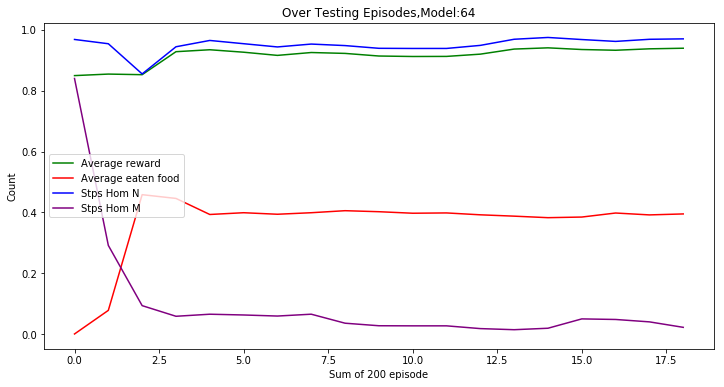

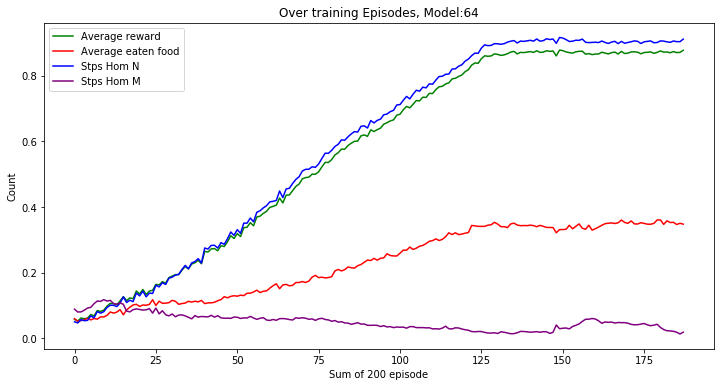

In [25]:
for i in range(64,65):
    x = pd.read_csv('output/{}/exp_details.csv'.format(i),header=None)
    Normalizedata(x,[2,8,9,10])
    plotdata(x,200,i)

Model:64


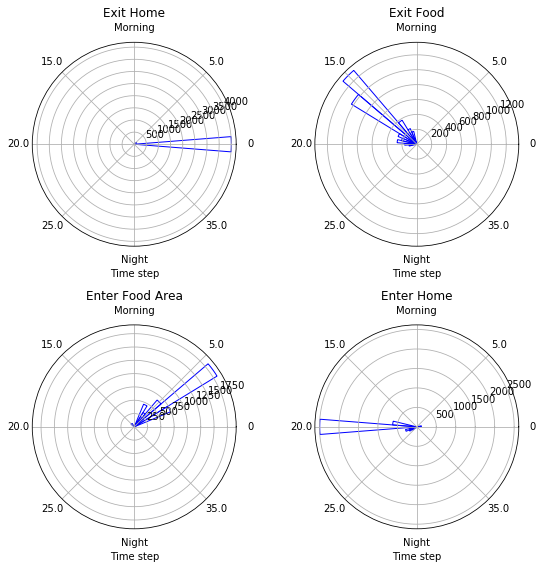

In [29]:
for i in range(64,65):
    data = pd.read_csv('output/{}/df.csv'.format(i),header=None)
    rose_plot(i,data,cycles=4,combined=True,length=160)

### Experiment 64 - Lstm analysis.

In [39]:
hidden_states = np.load('output/64/lstm_states.npy')

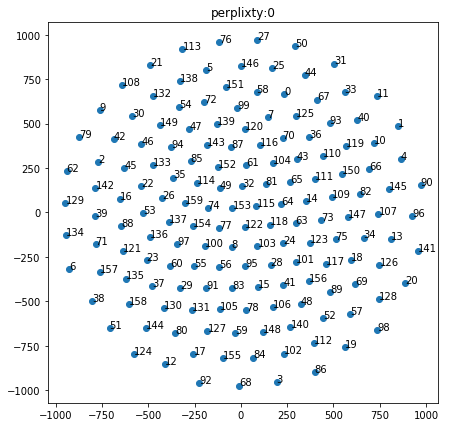

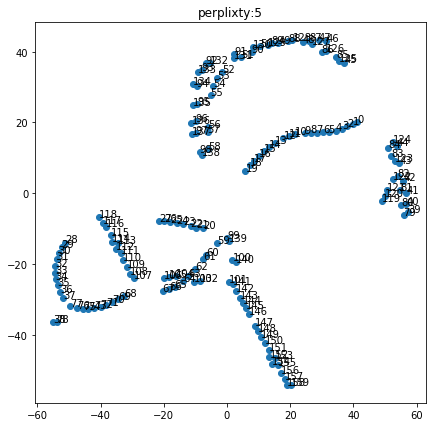

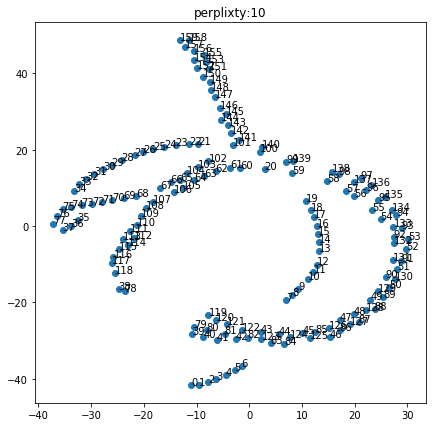

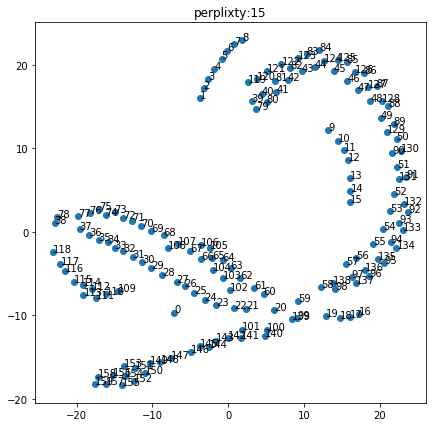

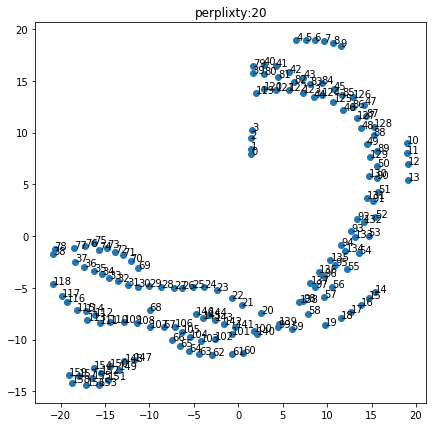

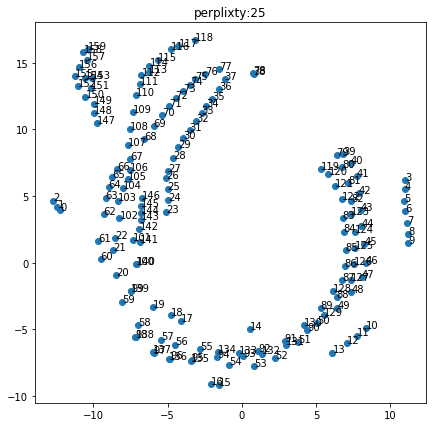

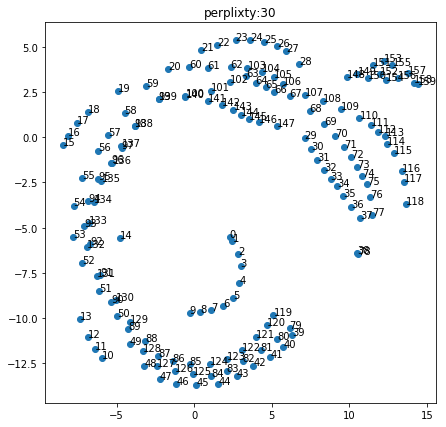

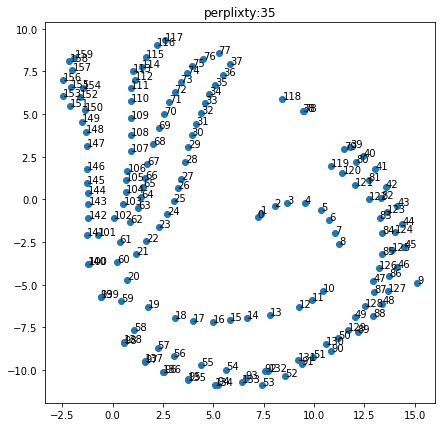

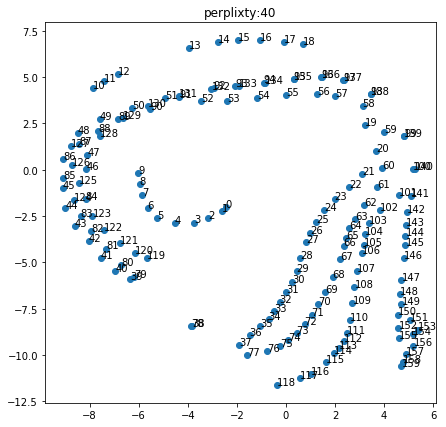

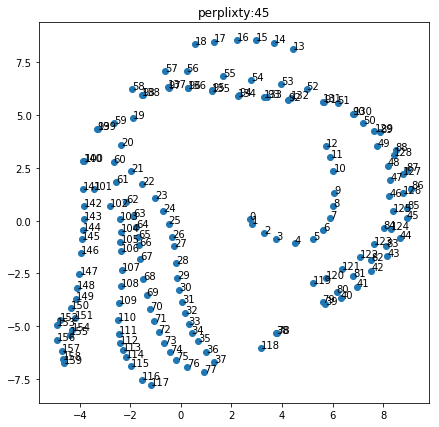

In [19]:
Calculate_TSNE(hidden_states[0,:,:],seed=1377,counter=hidden_states[0,:,:].shape[0])

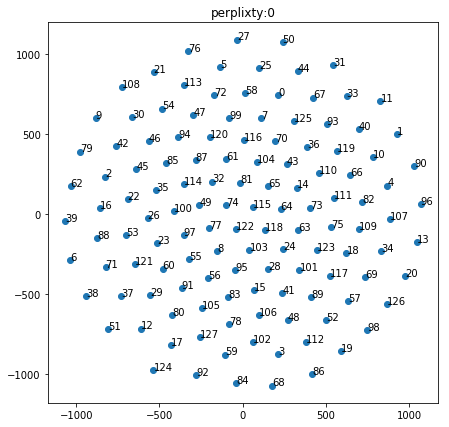

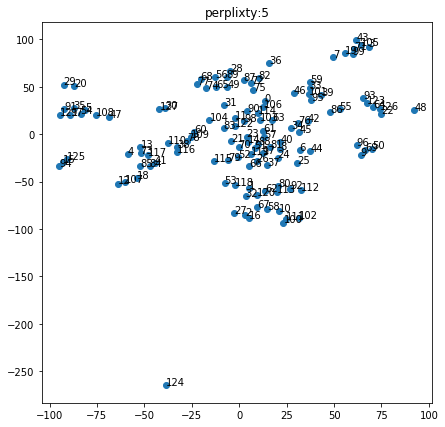

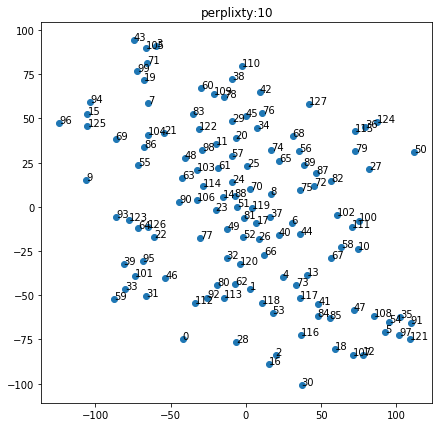

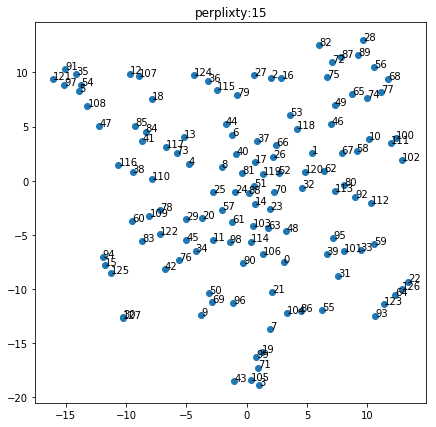

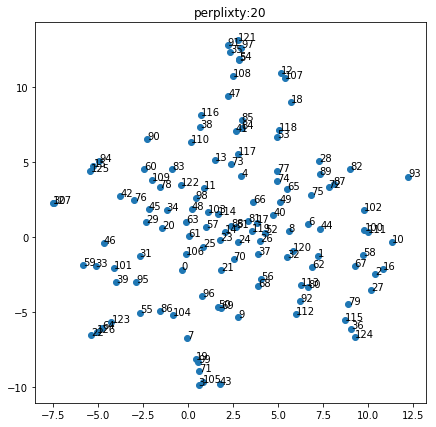

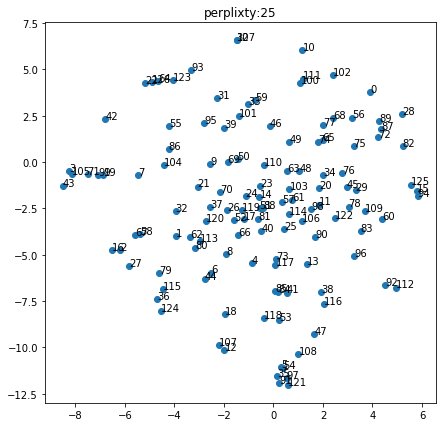

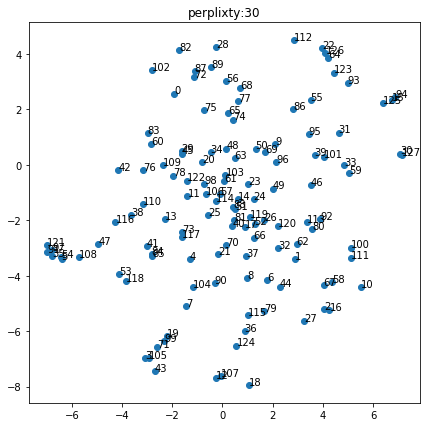

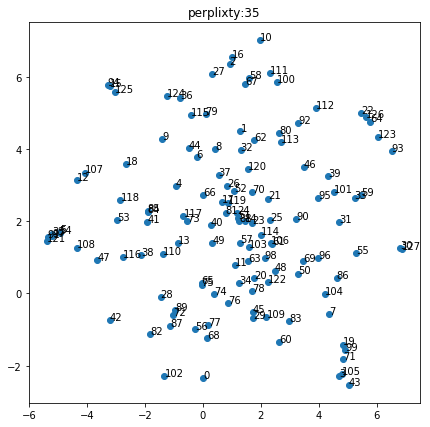

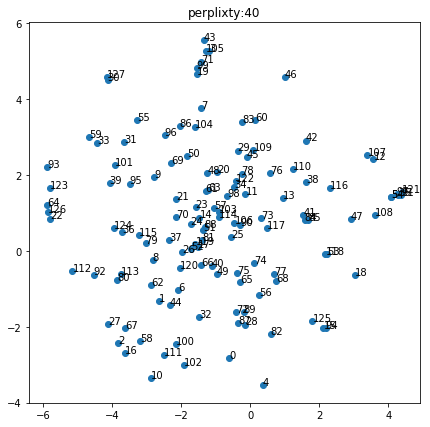

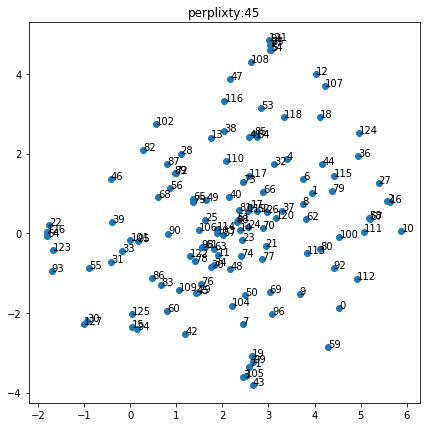

In [20]:
Calculate_TSNE(hidden_states[0,:,:].T,seed=1377,counter=hidden_states[0,:,:].T.shape[0])

In [40]:
important_n = [1,2,3,4,5,6,16,27,29,35,38,57,62,64,71,80,84,91,94,95,127]

In [41]:
important_n = [1]

In [3]:
hs,d = Read_Data(64)

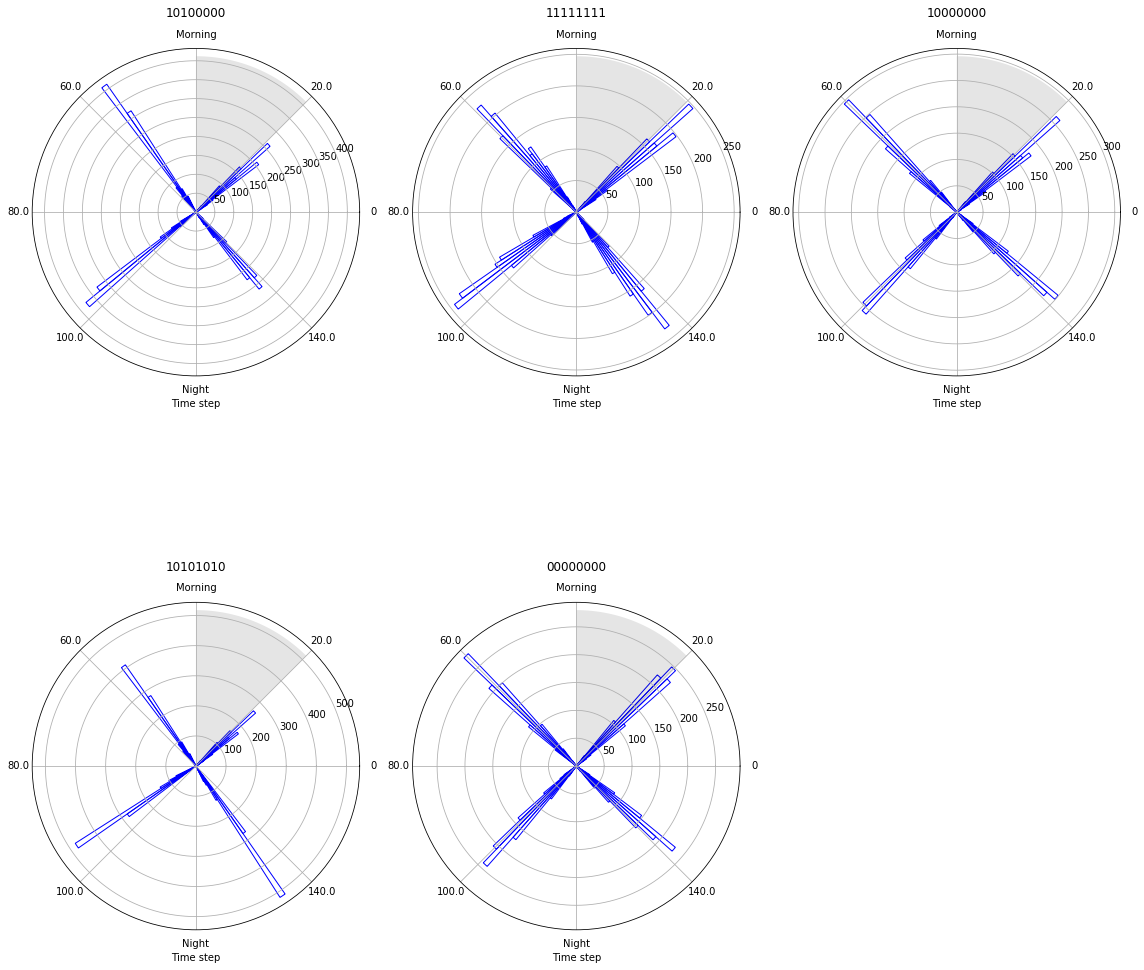

In [10]:
rn =rose_plot_compare(d,cycles=4,combined=False,length=160)

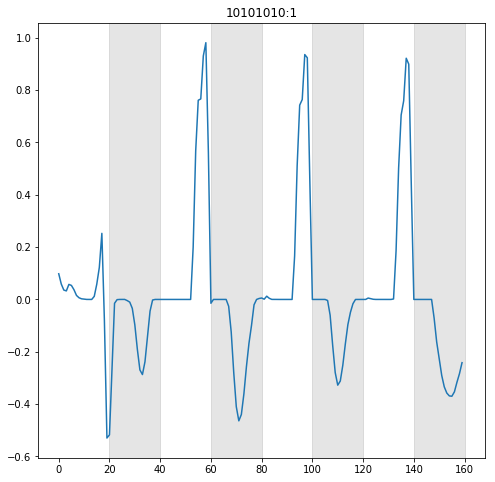

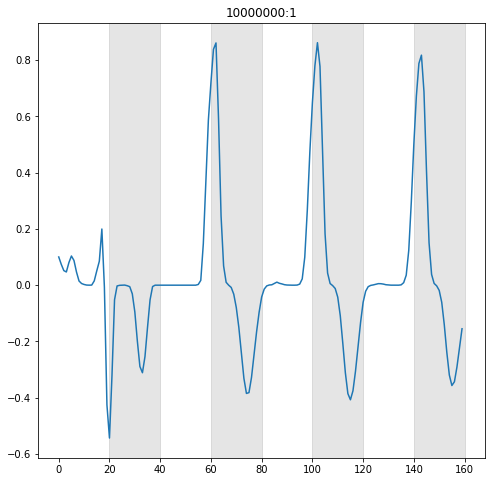

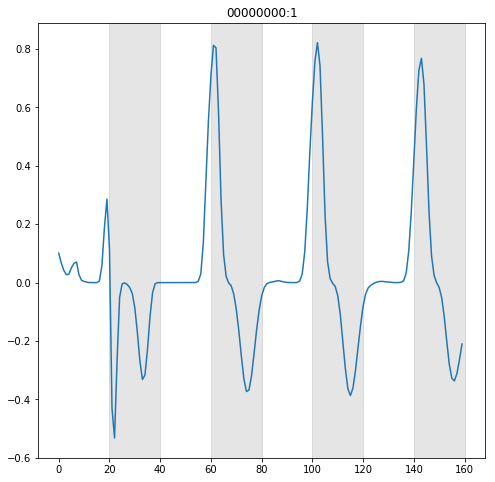

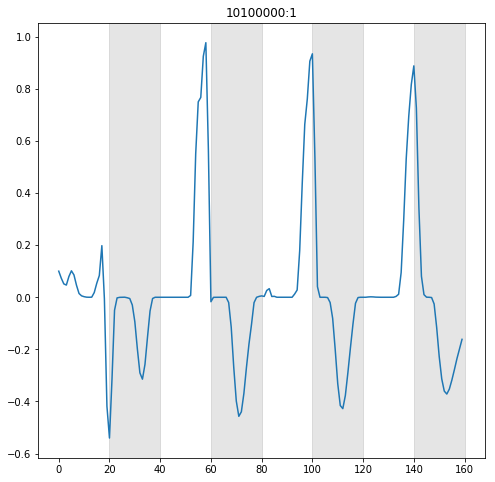

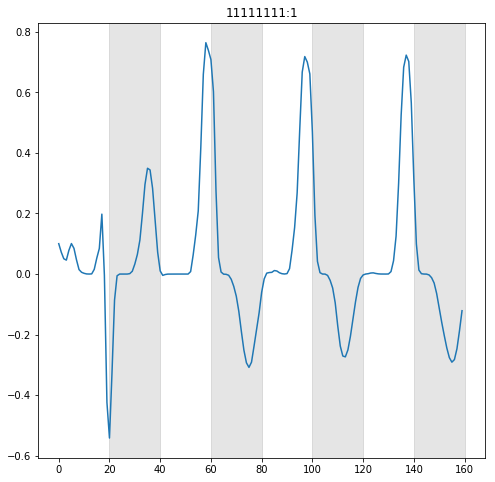

In [43]:
for i in important_n:
    neuron_activity(hidden_states[:,:,i].mean(axis=0),cycles=4)
    plt.title('10101010:{}'.format(i))
    neuron_activity(hidden_states_10000000[:,:,i].mean(axis=0),cycles=4)
    plt.title('10000000:{}'.format(i))
    neuron_activity(hidden_states_00000000[:,:,i].mean(axis=0),cycles=4)
    plt.title('00000000:{}'.format(i))
    neuron_activity(hidden_states_10100000[:,:,i].mean(axis=0),cycles=4)
    plt.title('10100000:{}'.format(i))
    neuron_activity(hidden_states_11111111[:,:,i].mean(axis=0),cycles=4)
    plt.title('11111111:{}'.format(i))

In [11]:
rose_plot(65,data,cycles=4,combined=False,length=160)

NameError: name 'data' is not defined

Model:64


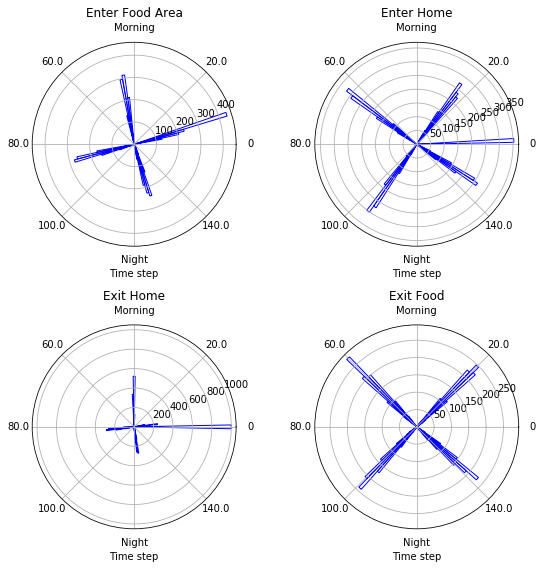

In [52]:
rose_plot(64,data_00000000,cycles=4,combined=False,length=160)

Model:64


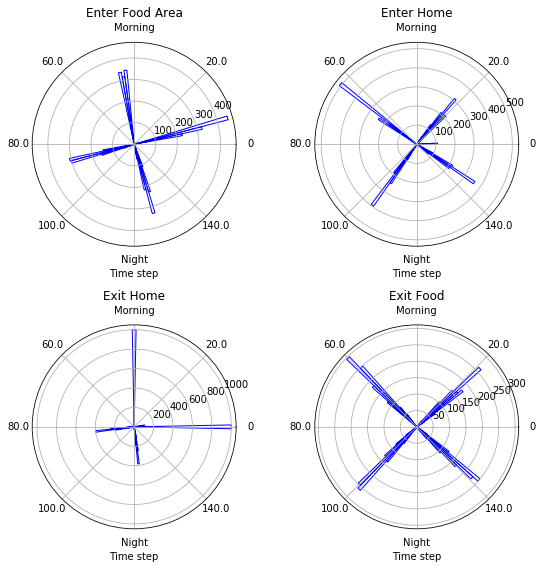

In [51]:
rose_plot(64,data_10000000,cycles=4,combined=False,length=160)

Model:64


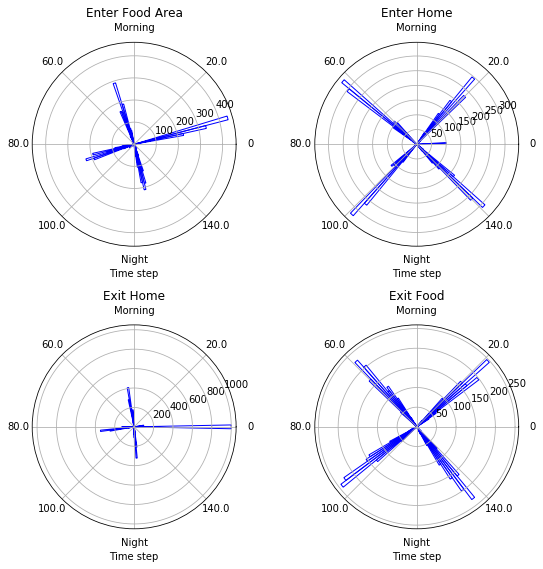

In [50]:
rose_plot(64,data_11111111,cycles=4,combined=False,length=160)